In [2]:
%pylab inline

import gc
import fpfs
import numpy as np
from fpfs import simutil
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel
import pdet
import pltutil
wDir=os.path.join(os.environ['homeWrk'],'FPFS2')

Populating the interactive namespace from numpy and matplotlib


/lustre/work/xiangchong.li/ana/miniconda3/envs/cosmosis-mpich/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
ishear=1
igroup=0
do_plot=False
ngrid=64
if igroup>=0:
    ngal=100
    img1=pyfits.getdata(os.path.join(wDir,'sim/galaxy_basicCenter_psf60/image-%d-g%d-0000.fits' %(igroup,ishear)))
    img2=pyfits.getdata(os.path.join(wDir,'sim/galaxy_basicCenter_psf60/image-%d-g%d-2222.fits' %(igroup,ishear)))
else:
    ngal=10
    img1=simutil.make_basic_sim('basicCenter_psf60','g%d-0000' %ishear,0,ny=ngal,nx=ngal,do_write=False)
    img2=simutil.make_basic_sim('basicCenter_psf60','g%d-2222' %ishear,0,ny=ngal,nx=ngal,do_write=False)
ngrid2=ngrid*ngal

# PSF
psf=pyfits.getdata(os.path.join(wDir,'sim/galaxy_basic_psf60/psf-60.fits'))
npad       =   (ngrid2-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid2
psfF=np.fft.fft2(np.fft.ifftshift(psfData))
gsigma=3.*2.*np.pi/64
x   = np.fft.fftfreq(ngrid2,1/np.pi/2.)

gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
k2grid,k1grid=grids

imgF1=np.fft.fft2(img1)/psfF*gKer
imgF2=np.fft.fft2(img2)/psfF*gKer
imgCov1=np.fft.ifft2(imgF1).real
imgCov2=np.fft.ifft2(imgF2).real
gc.collect()

28

In [4]:
npixt = 1
sizet = 1 + 2 * npixt

footprint = np.zeros((sizet, sizet))
footprint[npixt, npixt] = 1.
footprint[npixt+1, npixt] = -1.
imgCovACov1=ndi.convolve(imgCov1,footprint,mode='constant')
gc.collect()

23

In [5]:
thres=1.*np.sqrt(4e-3)
indX=np.arange(32,ngal*64,64)
indY=np.arange(32,ngal*64,64)
inds=np.meshgrid(indY,indX,indexing='ij')

In [6]:
if True:
    coords   = np.array(np.zeros(inds[0].size),dtype=[('pdet_y','i4'),('pdet_x','i4')])
    coords['pdet_y']=np.ravel(inds[0])
    coords['pdet_x']=np.ravel(inds[1])
else:
    coords=pdet.detect_coords(imgCov1,thres)

10000


10

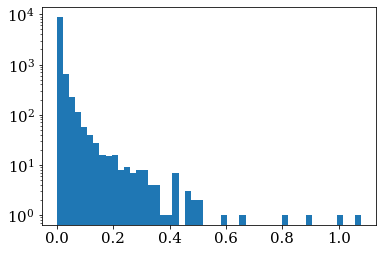

In [7]:
print(len(coords))
plt.close()
plt.hist(imgCovACov1[coords['pdet_y'],coords['pdet_x']],bins=50)
plt.yscale('log')
gc.collect()

13034

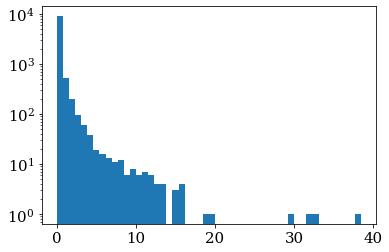

In [8]:
plt.close()
plt.hist(imgCov1[coords['pdet_y'],coords['pdet_x']],bins=50)
plt.yscale('log')
gc.collect()

In [9]:
out1=pdet.get_shear_response(img1,psfData,gsigma=6*2*np.pi/64,coords=coords)
out2=pdet.get_shear_response(img2,psfData,gsigma=6*2*np.pi/64,coords=coords)

In [21]:
for j in range(1,4):
    for i in range(1,4):
        print(j,i)
        resEst=(out2['pdet_v%d%d' %(j,i)]-out1['pdet_v%d%d'%(j,i)])/0.04
        res=(out2['pdet_v%d%dr%d'%(j,i,ishear)]+out1['pdet_v%d%dr%d'%(j,i,ishear)])/2.
        print(np.average((res-resEst)/np.abs(resEst)),np.argmax(np.abs((res-resEst)/resEst)))
        print(np.abs((res-resEst)/resEst))
        break

1 1
4.376968682417121e-05 6345
[0.0019717  0.00058608 0.00072386 ... 0.00103501 0.00061758 0.00089157]
2 1
0.0013431791350987867 1857
[0.00127664 0.0002623  0.00063356 ... 0.00144484 0.00058407 0.000665  ]
3 1
-2.3138129169392546e-05 7903
[0.00268173 0.00035459 0.00061597 ... 0.00101553 0.00068214 0.00063861]
